# Running Simulations and Making Analyzations With pyqg

Using `pyqg`, we can run unique high-resolution simulations of our own. To start, import the following modules/packages:

In [1]:
import numpy as np
import xarray as xr
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import pyqg 
import pyqg.diagnostic_tools as tools
import seaborn as sns

%matplotlib inline

We will use the `pyqg.QGModel` class to generate the two layer quasigeostrophic models we will be running simulations on. There is a base class from which all other models inherit, `pyqg.Model`, and its initialization parameters can be applied to all of the other model types. Although there are numerous parameters that can be set and played around with, the following parameters from the base class are of main focus to reproducing the high resolution simulations from the paper. 

* `nx`: number of real space grid points in the $x$ direction (affects the resolution of the simulations)
* `dt`: numerical timestep
* `tmax`: total time of integration (units: model time)
* `tavestart`: start time for averaging (units: model time)

Setting these parameters will result in a model under an eddy-like configuration. To create a model under a jet-structured configuration, you must initialize the following parameters decidedly:

* `rek`: linear drag in lower layer. Units: seconds<sup>-1</sup>
* `delta`: layer thickness ratio (H1/H2)
* `beta`: gradient (slope) of Coriolis parameter. Units: meters<sup>-1</sup> seconds<sup>-1</sup>

In the paper, the following arguments were passed to create the eddy and jet models that were simulated:

In [5]:
eddy_model = pyqg.QGModel(nx=256, dt=3600.0, tmax=311040000.0, tavestart=155520000.0)
jet_model = pyqg.QGModel(nx=256, dt=3600.0, tmax=311040000.0, tavestart=155520000.0, rek=7e-08, delta=0.1, beta=1e-11)

INFO:  Logger initialized
INFO:  Logger initialized


The argument values can be played around with to produce different effects and behaviours from the simulation. For instance, decreasing the value on the `nx` parameter will result in a lower resolution simulation. To better understand the other parameters and default argument values on the model class, take a further look at `pyqg`'s official and latest API documentation [page](https://pyqg.readthedocs.io/en/latest/api.html).

We can then call `run()` to run the respective models forward without stopping until the end. Each of the above models are run over a span of 10 years with averages starting to be taken at 5 years in numerical time steps of 1 hour.

In [6]:
# From here, you can call .run() to run a new simulation
eddy_model.run()
jet_model.run()

# Convert to xarray Datasets
eddy_high_res = eddy_model.to_dataset()
jet_high_res = jet_model.to_dataset()

INFO: Step: 1000, Time: 3.60e+06, KE: 1.40e-07, CFL: 0.023
INFO: Step: 2000, Time: 7.20e+06, KE: 1.54e-07, CFL: 0.023
INFO: Step: 3000, Time: 1.08e+07, KE: 1.92e-07, CFL: 0.023
INFO: Step: 4000, Time: 1.44e+07, KE: 2.54e-07, CFL: 0.023
INFO: Step: 5000, Time: 1.80e+07, KE: 3.51e-07, CFL: 0.023
INFO: Step: 6000, Time: 2.16e+07, KE: 5.07e-07, CFL: 0.023
INFO: Step: 7000, Time: 2.52e+07, KE: 7.59e-07, CFL: 0.023
INFO: Step: 8000, Time: 2.88e+07, KE: 1.17e-06, CFL: 0.023
INFO: Step: 9000, Time: 3.24e+07, KE: 1.83e-06, CFL: 0.023
INFO: Step: 10000, Time: 3.60e+07, KE: 2.92e-06, CFL: 0.023
INFO: Step: 11000, Time: 3.96e+07, KE: 4.70e-06, CFL: 0.023
INFO: Step: 12000, Time: 4.32e+07, KE: 7.66e-06, CFL: 0.024
INFO: Step: 13000, Time: 4.68e+07, KE: 1.26e-05, CFL: 0.023
INFO: Step: 14000, Time: 5.04e+07, KE: 2.07e-05, CFL: 0.026
INFO: Step: 15000, Time: 5.40e+07, KE: 3.43e-05, CFL: 0.035
INFO: Step: 16000, Time: 5.76e+07, KE: 5.72e-05, CFL: 0.045
INFO: Step: 17000, Time: 6.12e+07, KE: 9.56e-05, 

To run a simulation with snapshot variables saved periodically, we use `generate_snapshots()` and concatenate each of the resulting snapshots for each configuration setting into cumulative `xarray.Dataset` objects. Below, we are saving snapshots every 1000 hours.

In [7]:
def generate_snapshots(model):
    snapshots = []
    snapshots.append(model.to_dataset())
    for _ in model.run_with_snapshots(tsnapint=1000*model.dt):
        snapshots.append(model.to_dataset())
    return xr.concat(snapshots, dim='time')

eddy_high_res = generate_snapshots(eddy_model)
jet_high_res = generate_snapshots(jet_model)

The `xarray.Dataset` objects additionally store some documentation for each variable:

In [8]:
eddy_high_res

<xarray.Dataset>
Dimensions:            (time: 1, lev: 2, y: 256, x: 256, l: 256, k: 129,
                        lev_mid: 1)
Coordinates:
  * time               (time) float64 3.11e+08
  * lev                (lev) int32 1 2
  * lev_mid            (lev_mid) float64 1.5
  * x                  (x) float64 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
  * y                  (y) float64 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
  * l                  (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * k                  (k) float64 0.0 6.283e-06 ... 0.000798 0.0008042
Data variables: (12/32)
    q                  (time, lev, y, x) float64 6.323e-06 ... 4.992e-07
    u                  (time, lev, y, x) float64 0.05528 0.05886 ... -0.006127
    v                  (time, lev, y, x) float64 0.001331 -0.002689 ... 0.00983
    ufull              (time, lev, y, x) float64 0.08028 0.08386 ... -0.006127
    vfull              (time, lev, y, x) float64 0.001331 -0.002689 ... 0.00983
    qh                 (time, lev, l, k) complex128 (0.03626500243545644+0j) ...
    ...                 ...
    ENSgenspec         (time, l, k) float64 0.0 -4.287e-23 ... 5.472e-67
    ENSfrictionspec    (time, l, k) float64 0.0 -2.317e-24 ... -1.313e-65
    APEgenspec         (time, l, k) float64 0.0 -9.645e-15 ... 1.231e-58
    APEflux            (time, l, k) float64 -0.0 7.437e-15 ... 6.792e-39
    KEflux             (time, l, k) float64 0.0 7.811e-15 ... 3.422e-35
    APEgen             (time) float64 8.103e-11
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         86400
    pyqg:tmax:       311040000.0
    pyqg:twrite:     1000.0
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

## Retrieving Preexisting Datasets

Alternatively, with preexisting datasets, we can replicate the procedures followed within the paper using the same high resolution datasets that were generated in the study. We can retrieve the exact datasets stored on a persistent storage bucket within Jupyter Hub. The datasets are organized as `zarr` files in the following top-down fashion:

```
eddy/
    high_res.zarr
    low_res.zarr
    forcing1.zarr
    forcing2.zarr
    forcing3.zarr
jet/
    high_res.zarr
    low_res.zarr
    forcing1.zarr
    forcing2.zarr
    forcing3.zarr
```

Where the top-level directories (`eddy` and `jet`) delineate the configurations under which the `pyqg.QGModel` simulations were run under.

In [12]:
# Fives runs total were made, the following gets the model output from the first run
eddy_high_res = xr.open_zarr('gs://leap-persistent/pbluc/eddy/high_res').isel(run=0).load()
jet_high_res = xr.open_zarr('gs://leap-persistent/pbluc/jet/high_res').isel(run=0).load()

ValueError: unrecognized engine zarr must be one of: ['scipy', 'store']

`high_res.zarr` contains snapshots and diagnostics for high resolution eddy- and jet-configured models (where `nx=256`). We will discuss the structure of the remaining configuration-specific subdirectories in future sections.

## Visualizing the Output

### State Variables

The `xarray.Dataset` objects contain various variables including state and diagnostic variables. Using the state variables, we can visualize the results of the simulations we run. The following state variables are stored in each dataset: 

* `q`: potential vorticity (PV) in real space
* `u`: the zonal velocity anomaly or the $x$-velocity relative to the background flow
* `v`: meridional velocity anomaly or the $y$-velocity relative to the background flow
* `ufull` and `vfull` - corresponding variables of the full velocities in real space, including the background flow
* `streamfunction`

Examples of snapshot depictions that we can make using these variables include snapshots of the upper and lower PV, kinetic energy density, and enstrophy for the simulations, in both eddy and jet configurations.

We can plot snapshots of the PV in both levels simply using `q` from each dataset.

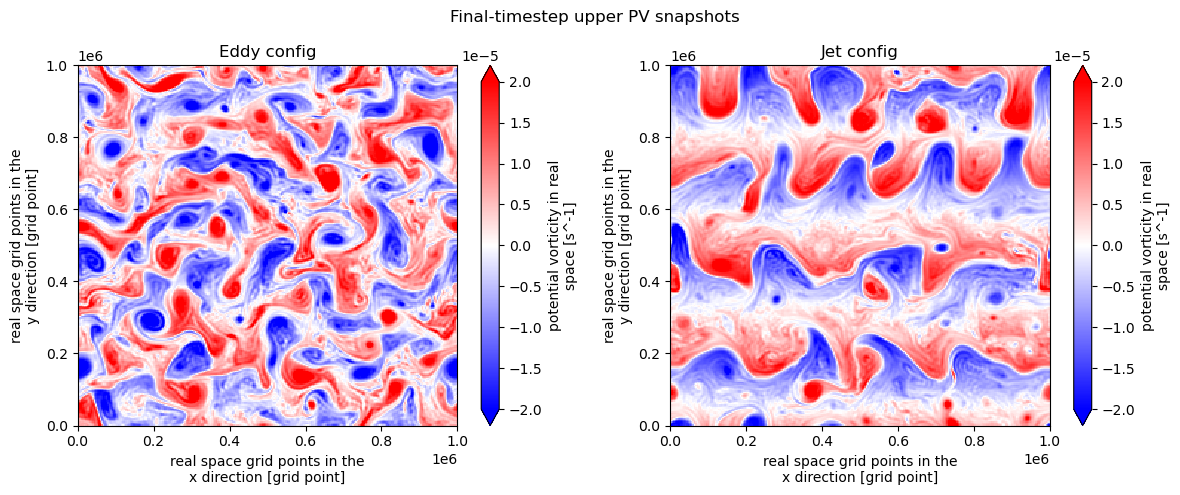

In [15]:
plt.figure(figsize=(12,5)).suptitle("Final-timestep upper PV snapshots")
plt.subplot(121); eddy_high_res.q.isel(lev=0, time=-1).plot(vmin=-2e-5, vmax=2e-5, cmap='bwr'); plt.title("Eddy config")
plt.subplot(122);  jet_high_res.q.isel(lev=0, time=-1).plot(vmin=-2e-5, vmax=2e-5, cmap='bwr'); plt.title( "Jet config")
plt.tight_layout()

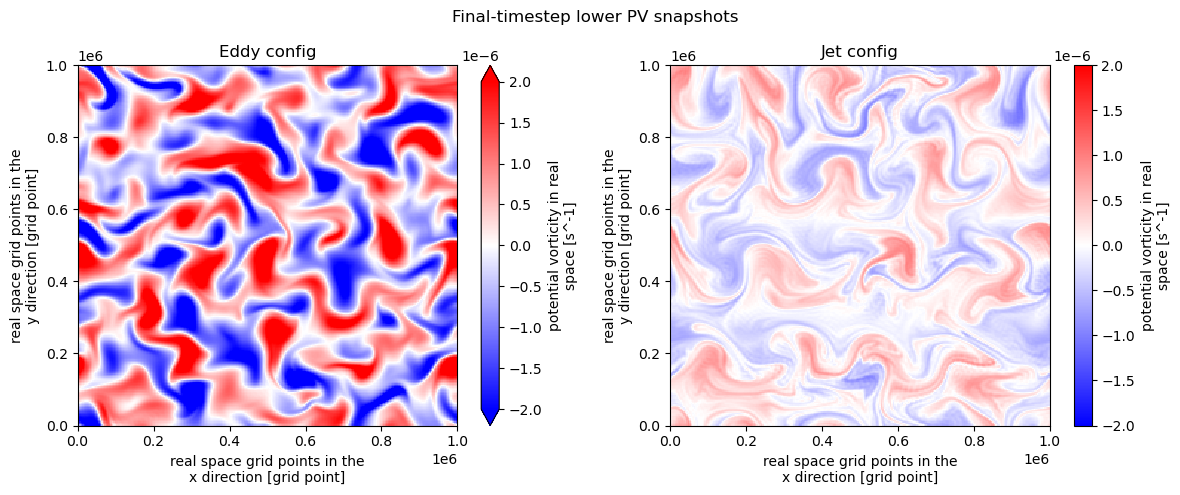

In [14]:
plt.figure(figsize=(12,5)).suptitle("Final-timestep lower PV snapshots")
plt.subplot(121); eddy_high_res.q.isel(lev=1, time=-1).plot(vmin=-2e-6, vmax=2e-6, cmap='bwr'); plt.title("Eddy config")
plt.subplot(122);  jet_high_res.q.isel(lev=1, time=-1).plot(vmin=-2e-6, vmax=2e-6, cmap='bwr'); plt.title( "Jet config")
plt.tight_layout()

To plot snapshots of the kinetic energy density, we use the state variables `u` and `v`, to calculate the sum of the kinetic energy density, $(u^2 + v^2) / 2$, at each layer.

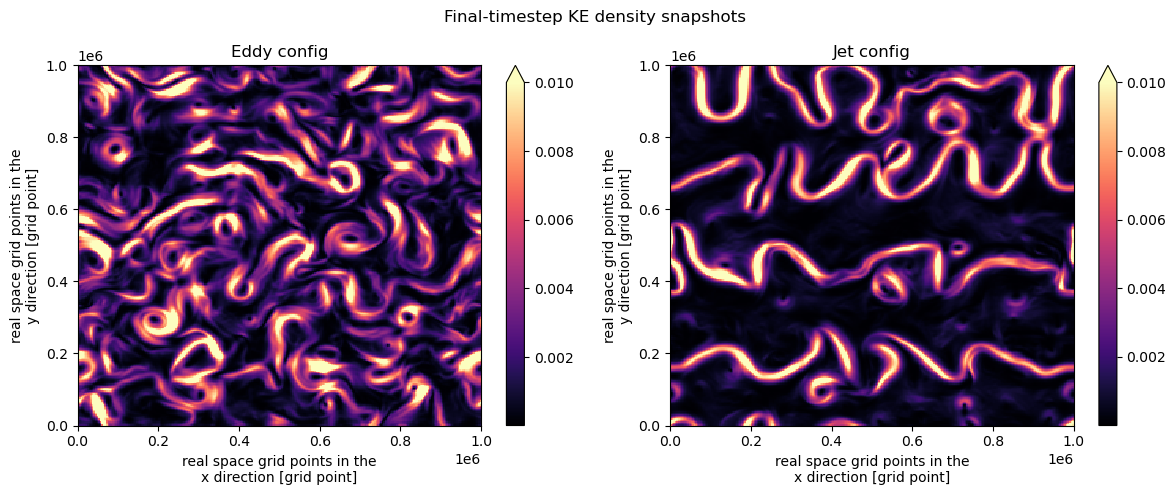

In [16]:
eddy_ke_density = ((eddy_high_res.u * eddy_high_res.u) + (eddy_high_res.v * eddy_high_res.v)) / 2
jet_ke_density = ((jet_high_res.u * jet_high_res.u) + (jet_high_res.v * jet_high_res.v)) / 2

plt.figure(figsize=(12,5)).suptitle("Final-timestep KE density snapshots")
plt.subplot(121); eddy_ke_density.sum(dim=['lev']).isel(time=-1).plot(vmax=1e-2, cmap='magma'); plt.title("Eddy config")
plt.subplot(122);  jet_ke_density.sum(dim=['lev']).isel(time=-1).plot(vmax=1e-2, cmap='magma'); plt.title( "Jet config")
plt.tight_layout()

Traditionally, the enstrophy is calculated as the $\text{curl}^{2}(\vec{u})/2$. However `pygq`'s calculation of enstrophy is made without taking any gradient operations as it is based on the PV instead. Thus, to plot snapshots of the enstrophy, we use only the state variable `q` to calculate the enstrophy as $q^{2}/2$, at each layer. Though it is to be noted that this calculation of enstrophy has an extra term that is specific to QG models thus using the gradient calculated enstrophy is more standard in practice.

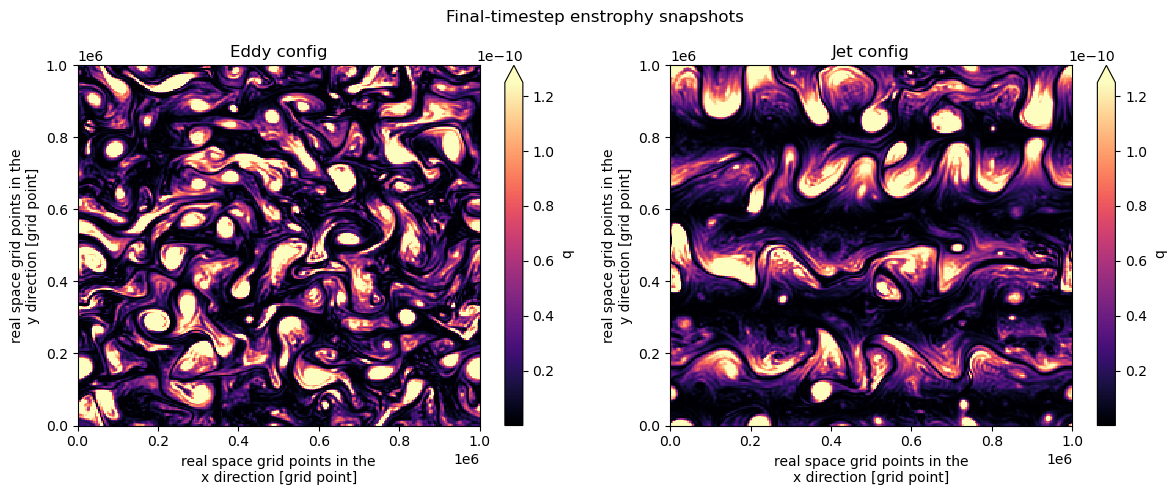

In [17]:
eddy_enstrophy = (eddy_high_res.q * eddy_high_res.q) / 2
jet_enstrophy = (jet_high_res.q * jet_high_res.q) / 2

plt.figure(figsize=(12,5)).suptitle("Final-timestep enstrophy snapshots")
plt.subplot(121); eddy_enstrophy.sum(dim=['lev']).isel(time=-1).plot(vmax=1.25e-10, cmap='magma'); plt.title("Eddy config")
plt.subplot(122);  jet_enstrophy.sum(dim=['lev']).isel(time=-1).plot(vmax=1.25e-10, cmap='magma'); plt.title( "Jet config")
plt.tight_layout()

### Diagnostic Variables

Now we can also employ more diagnostic-type variables to aide in quantifying how entities such as energy, and, enstrophy, are distributed and transferred across scales. These variables are most useful when plotted for high and low resolution simulations as well as parameterized simulations. 

#### Power Spectra
* `KEspec`: how much kinetic energy is stored at each $x$ and $y$ lengthscale
* `Ensspec`: how much enstrophy is stored at each $x$ and $y$ lengthscale

#### Energy budget
* `KEflux`: how kinetic energy is being transferred across lengthscales
* `APEflux`: how available potential energy is being transferred across lengthscales
* `APEgenspec`: how much new available potential energy is being generated at each scale
* `KEfrictionspec`: how much energy is being lost to bottom drag at each lengthscale
* `Dissspec`: how much energy is being lost due to numerical dissipation at each lengthscale

#### Enstrophy budget
- `ENSflux`: how enstrophy is being transferred across lengthscales
- `ENSgenspec`: how much new enstrophy is being generated
- `ENSfrictionspec`: how much enstrophy is lost to bottom drag
- `ENSDissspec`: how much enstrophy is lost to numerical dissipation

Using a selection of these variables, we will plot the time-averaged kinetic energy power spectrum summed over fluid layers, time-series of total kinetic energy, spatially flattened probability distribution of upper layer PV, and spectral energy flux terms for eddy configuration simulations as examples of how these diagnostics can be plotted.

In [18]:
# Using diagnostics from final timestamp of eddy configuration
eddy_model_ds = eddy_high_res.isel(time=-1)

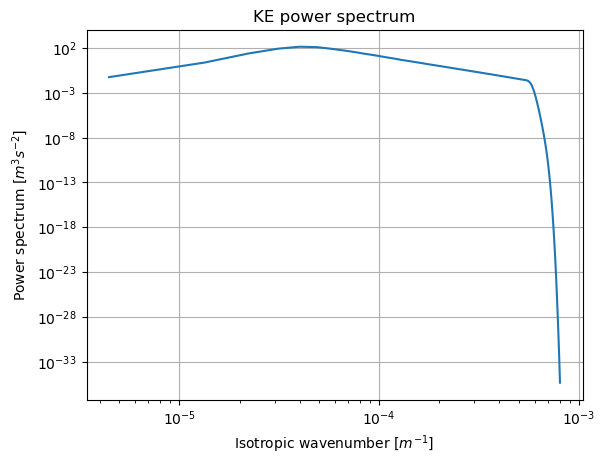

In [19]:
# Time-averaged kinetic energy power spectra summed over fluid layers
kr, KEspec_upper = tools.calc_ispec(eddy_model, eddy_model_ds.KEspec.isel(lev=0).data)
_, KEspec_lower  = tools.calc_ispec(eddy_model, eddy_model_ds.KEspec.isel(lev=1).data)

plt.loglog(kr, KEspec_upper + KEspec_lower)
plt.xlabel(r'Isotropic wavenumber [$m^{-1}$]')
plt.ylabel(r'Power spectrum [$m^{3}s^{-2}$]')
plt.title('KE power spectrum')
plt.grid()

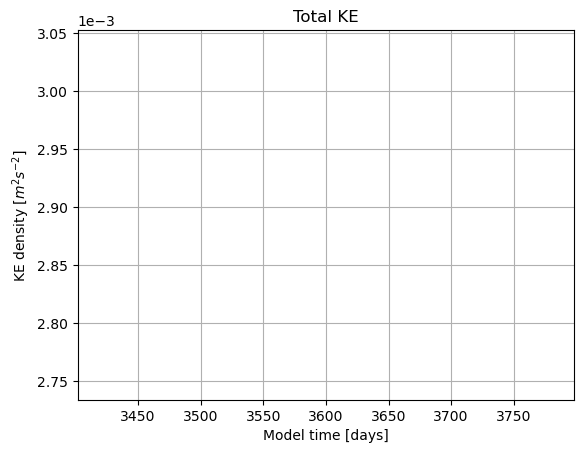

In [20]:
# Time-series of total kinetic energy
eddy_ke_density = ((eddy_high_res.u * eddy_high_res.u) + (eddy_high_res.v * eddy_high_res.v)) / 2
eddy_ke_density = eddy_ke_density.sum(dim=['lev']).mean(dim=['x', 'y'])

plt.plot(eddy_high_res['time'] / 86400,  eddy_ke_density)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('Model time [days]')
plt.ylabel(r'KE density [$m^{2}s^{-2}$]')
plt.title('Total KE')
plt.grid()

c:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


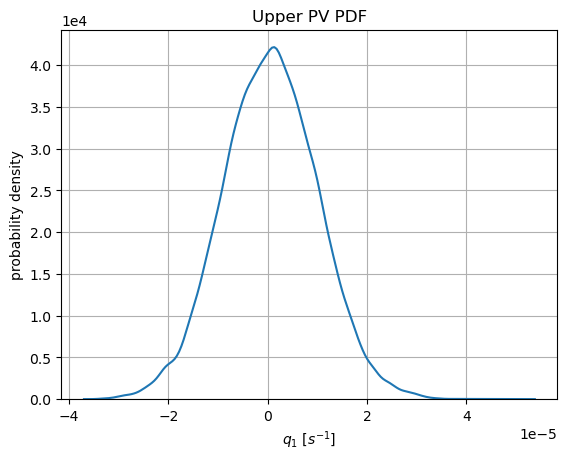

In [21]:
# Spatially flattened probability distributiom of upper layer PV
sns.kdeplot(np.reshape(eddy_model_ds.q.isel(lev=0).values, (-1)))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel(r'$q_{1}$ [$s^{-1}$]')
plt.ylabel('probability density')
plt.title('Upper PV PDF')
plt.grid()

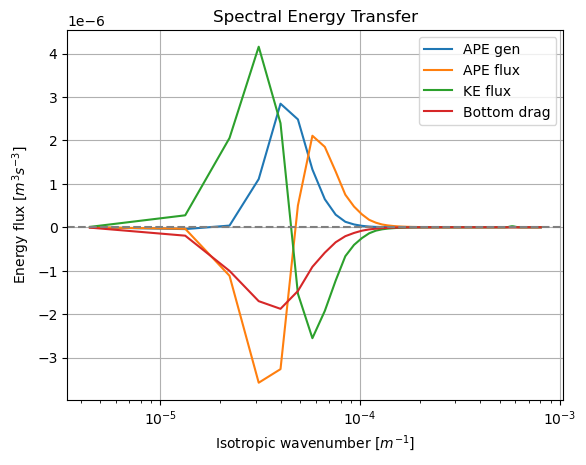

In [22]:
# Spectral energy flux terms 
kr, APEgenspec = tools.calc_ispec(eddy_model, eddy_model_ds.APEgenspec.data)
_, APEflux     = tools.calc_ispec(eddy_model, eddy_model_ds.APEflux.data)
_, KEflux      = tools.calc_ispec(eddy_model, eddy_model_ds.KEflux.data)
_, KEfrictionspec = tools.calc_ispec(eddy_model, eddy_model_ds.KEfrictionspec.data)

energy_budget = [ APEgenspec,
                  APEflux,
                  KEflux,
                  KEfrictionspec]
energy_budget_labels = ['APE gen','APE flux','KE flux','Bottom drag']
[plt.semilogx(kr, term) for term in energy_budget]
plt.axhline(0, color='gray', ls='--')
plt.legend(energy_budget_labels, loc='upper right')
plt.xlabel(r'Isotropic wavenumber [$m^{-1}$]'); 
plt.ylabel(r'Energy flux [$m^{3}s^{-3}$]'); 
plt.title('Spectral Energy Transfer');
plt.grid()